# COURSE:   PGP [AI&ML]

## Learner :  Chaitanya Kumar Battula
## Module  : Advanced Deep Learning
## Topic   : Model Prediction _ Pre-trained Model

#### Download a trained model

We will download a trained model from [TensorFlow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models-coco-models). If you already have a trained model then you can use the same here.

In [1]:
#Get trained model
!wget -q http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz

In [2]:
!ls -l

total 74752
drwxr-xr-x 1 root root     4096 Apr  7 13:36 sample_data
-rw-r--r-- 1 root root 76541073 Feb 10  2018 ssd_mobilenet_v1_coco_2018_01_28.tar.gz


In [3]:
#Unzip the file
!tar -xf ssd_mobilenet_v1_coco_2018_01_28.tar.gz

In [4]:
#check the unzipped files in the folder
!ls -l ssd_mobilenet_v1_coco_2018_01_28

total 58132
-rw-r--r-- 1 345018 5000       77 Feb  1  2018 checkpoint
-rw-r--r-- 1 345018 5000 29103956 Feb  1  2018 frozen_inference_graph.pb
-rw-r--r-- 1 345018 5000 27380740 Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 345018 5000     8937 Feb  1  2018 model.ckpt.index
-rw-r--r-- 1 345018 5000  3006546 Feb  1  2018 model.ckpt.meta
-rw-r--r-- 1 345018 5000     4138 Feb  1  2018 pipeline.config
drwxr-xr-x 3 345018 5000     4096 Feb  1  2018 saved_model


When we export the model (after training), we will get same set of files.

#### Load Model

In [5]:
#This code will work with tf 2.x
import tensorflow as tf

In [6]:
#Check the tf version
tf.__version__

'2.4.1'

In [7]:
#In tf2, we will use saved model rather than frozen_inference_graph.pb
model = tf.saved_model.load('ssd_mobilenet_v1_coco_2018_01_28/saved_model')
model = model.signatures['serving_default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
#Check model's input
model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

Here the model input tensor's name is 'image_tensor' and it has a 4D shape (first dimension is for batch size i.e how many images we will feed).

In [9]:
#Check model's output tensors
model.outputs

[<tf.Tensor 'detection_boxes:0' shape=(None, 100, 4) dtype=float32>,
 <tf.Tensor 'detection_classes:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'detection_scores:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'num_detections:0' shape=(None,) dtype=float32>]

How to understand 4 outputs here:



1.   **num_detections** : Number of prediction boxes we are getting from our model. We limit number of predictions in model configuration file. In this model, output will have top 100 predictions (out of 1000s of anchor boxes). Please note that we get this output after Non-Maximum supression (NMS) step has been completed.
2.   **detection_classes** : Index of the class with highest probability for each predicted box. These index values should be matched with index created using Label Encoder during training time. The values will between 1 to number of classes.
3.   **detection_scores** : Probability value for highest probability class for each box. The value will be between 0 to 1. This indicates how confident model of a real object in the box.
4.   **detection_boxes** : Boundary box co-ordinates for each predicted box. For each predicted box, we get 4 outputs i.e ymin, xmin, ymax, xmax. Please note that these are normalized values.



#### Load Class labels

Label dictionary (class index to class name mapping) should be taken from training module. Here is the dictionary which was used for this model.

In [10]:
all_classes = {1 : 'person' , 2: 'bicycle' , 3: 'car' , 4: 'motorcycle' , 5: 'airplane' , 6: 'bus' , 7: 'train' , 
               8: 'truck' , 9: 'boat' , 10: 'traffic light' , 11: 'fire hydrant' , 13: 'stop sign' , 14: 'parking meter' , 
               15: 'bench' , 16: 'bird' , 17: 'cat' , 18: 'dog' , 19: 'horse' , 20: 'sheep' , 21: 'cow' , 22: 'elephant' , 
               23: 'bear' , 24: 'zebra' , 25: 'giraffe' , 27: 'backpack' , 28: 'umbrella' , 31: 'handbag' , 32: 'tie' , 
               33: 'suitcase' , 34: 'frisbee' , 35: 'skis' , 36: 'snowboard' , 37: 'sports ball' , 38: 'kite' , 
               39: 'baseball bat' , 40: 'baseball glove' , 41: 'skateboard' , 42: 'surfboard' , 43: 'tennis racket' , 
               44: 'bottle' , 46: 'wine glass' , 47: 'cup' , 48: 'fork' , 49: 'knife' , 50: 'spoon' , 51: 'bowl' , 
               52: 'banana' , 53: 'apple' , 54: 'sandwich' , 55: 'orange' , 56: 'broccoli' , 57: 'carrot' , 58: 'hot dog' , 
               59: 'pizza' , 60: 'donut' , 61: 'cake' , 62: 'chair' , 63: 'couch' , 64: 'potted plant' , 65: 'bed' , 
               67: 'dining table' , 70: 'toilet' , 72: 'tv' , 73: 'laptop' , 74: 'mouse' , 75: 'remote' , 76: 'keyboard' , 
               77: 'cell phone' , 78: 'microwave' , 79: 'oven' , 80: 'toaster' , 81: 'sink' , 82: 'refrigerator' , 
               84: 'book' , 85: 'clock' , 86: 'vase' , 87: 'scissors' , 88: 'teddy bear' , 89: 'hair drier' , 90: 'toothbrush'}

In [11]:
all_classes[15]

'bench'

#### Model Prediction

In [12]:
#Function to get predictions from a Detection model
def detector_prediction(image_file, confidence_threshold=0.5):

    """
    image_file: File path of the image for which prediction needs to be done
    confidence_threshold: Minimum confidence/probability for prediction to be considered
    """
    #Load image
    img = tf.keras.preprocessing.image.load_img(image_file)
    
    #Convert to numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')
    #Make it a batch of one example
    img_array = tf.expand_dims(img_array, axis=0)

    #Prediction
    output = model(img_array) #get list of tensors discussed above as output
    detection_scores = output['detection_scores'].numpy()[0] #get detection scores
    detection_classes = output['detection_classes'].numpy()[0]
    detection_boxes = output['detection_boxes'].numpy()[0]

    #Select predictions for which probability is higher than confidence_threshold
    selected_predictions = detection_scores >= confidence_threshold

    selected_prediction_scores = detection_scores[selected_predictions]
    selected_prediction_classes = detection_classes[selected_predictions]
    selected_prediction_boxes = detection_boxes[selected_predictions]

    #De-normalize box co-ordinates (multiply x-coordinates by image width and y-coords by image height)
    img_w, img_h = img.size

    for i in range(selected_prediction_boxes.shape[0]):
        
        selected_prediction_boxes[i,0] *= img_h #ymin * img_w
        selected_prediction_boxes[i,1] *= img_w #xmin * img_h
        selected_prediction_boxes[i,2] *= img_h #ymax * img_w
        selected_prediction_boxes[i,3] *= img_w #xmax * img_h

    #Make all co-ordinates as integer
    selected_prediction_boxes= selected_prediction_boxes.astype(int)

    #Convert class indexes to actual class labels
    predicted_classes = []
    for i in range(selected_prediction_classes.shape[0]):
        predicted_classes.append(all_classes[int(selected_prediction_classes[i])])

    #Number of predictions
    selected_num_predictions = selected_prediction_boxes.shape[0]

    return {'Total Predictions': selected_num_predictions,
            'Scores': selected_prediction_scores, 
            'Classes': predicted_classes, 
            'Box coordinates': selected_prediction_boxes}

Let's download couple of images for which we will do predictions.

In [13]:
!wget https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image1.jpg --quiet
!wget https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image2.jpg --quiet

In [14]:
!ls -l

total 76272
-rw-r--r-- 1 root   root   129862 Apr 16 10:56 image1.jpg
-rw-r--r-- 1 root   root  1415684 Apr 16 10:56 image2.jpg
drwxr-xr-x 1 root   root     4096 Apr  7 13:36 sample_data
drwxr-xr-x 3 345018 5000     4096 Feb  1  2018 ssd_mobilenet_v1_coco_2018_01_28
-rw-r--r-- 1 root   root 76541073 Feb 10  2018 ssd_mobilenet_v1_coco_2018_01_28.tar.gz


In [15]:
#Model predictions for image1.jpg
detector_prediction('image2.jpg', confidence_threshold=0.3)

{'Box coordinates': array([[498, 532, 533, 553],
        [344, 467, 361, 485],
        [516,  77, 561, 101],
        [ 71, 591, 149, 676],
        [239, 271, 276, 301],
        [615, 106, 756, 159],
        [346, 583, 360, 605],
        [684, 212, 843, 272],
        [488, 346, 506, 361],
        [528,  36, 558,  55],
        [539, 181, 560, 196],
        [240, 283, 278, 314]]),
 'Classes': ['person',
  'kite',
  'person',
  'kite',
  'kite',
  'person',
  'kite',
  'person',
  'person',
  'person',
  'person',
  'kite'],
 'Scores': array([0.9168785 , 0.82944536, 0.7785056 , 0.76998675, 0.7555397 ,
        0.6342338 , 0.6074064 , 0.58910155, 0.51237667, 0.5014635 ,
        0.4556255 , 0.4176191 ], dtype=float32),
 'Total Predictions': 12}

#### Visualizing Model Prediction

In [16]:
import cv2
from matplotlib import pyplot as plt

In [17]:
def visualize_output(image_file, confidence_threshold=0.5):

    #Call model prediction function above
    output = detector_prediction(image_file, confidence_threshold=confidence_threshold)

    #Read image
    img = cv2.imread(image_file)

    #Draw rectangle for predicted boxes, also add predicted classes
    for i in range(output['Box coordinates'].shape[0]):

        box = output['Box coordinates'][i]
        
        #Draw rectangle 
        img = cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (0,255,0), 2)
        
        #Add Label - Class name and confidence level
        label = output['Classes'][i] + ': ' + str(round(output['Scores'][i],2))
        img = cv2.putText(img, label, (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    #Conver BGR image to RGB to use with Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Display image
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.show()

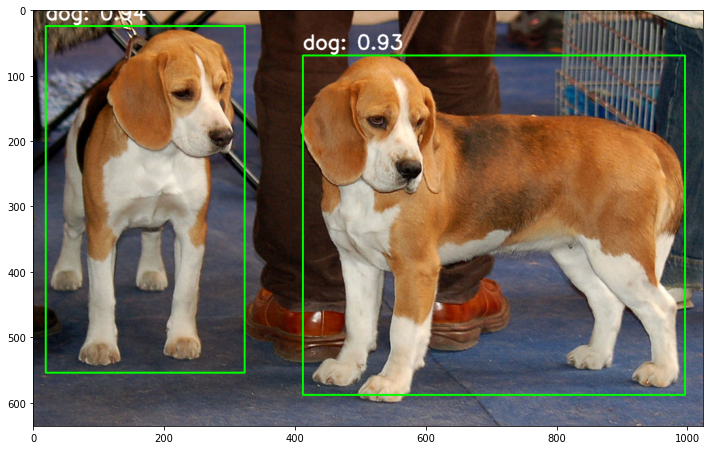

In [18]:
#Visualize first image
visualize_output('image1.jpg')

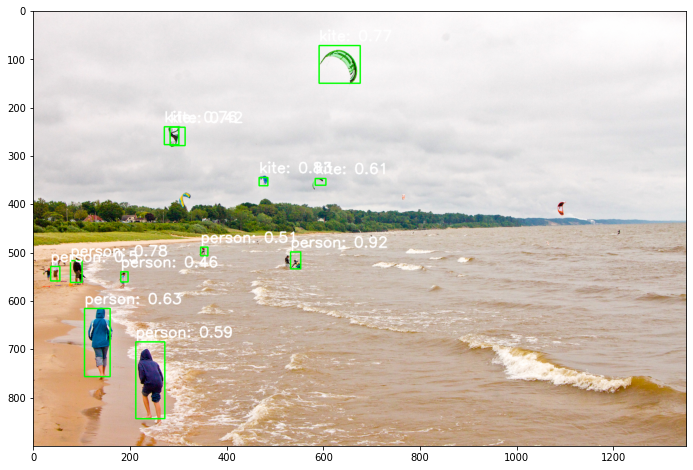

In [19]:
#Visualize second image
visualize_output('image2.jpg', confidence_threshold=0.3)

In [20]:
#Mount Google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [22]:
!cp '/gdrive/My Drive/Advanced Computer Vision AIML/Detection/Group Photo.jpeg' .
!ls -l

total 76312
-rw------- 1 root   root    39192 Apr 16 10:59 'Group Photo.jpeg'
-rw-r--r-- 1 root   root   129862 Apr 16 10:56  image1.jpg
-rw-r--r-- 1 root   root  1415684 Apr 16 10:56  image2.jpg
drwxr-xr-x 1 root   root     4096 Apr  7 13:36  sample_data
drwxr-xr-x 3 345018 5000     4096 Feb  1  2018  ssd_mobilenet_v1_coco_2018_01_28
-rw-r--r-- 1 root   root 76541073 Feb 10  2018  ssd_mobilenet_v1_coco_2018_01_28.tar.gz


In [24]:
#Model output
detector_prediction('Group Photo.jpeg', confidence_threshold=0.4)

{'Box coordinates': array([[ 83, 359, 260, 462],
        [114, 272, 293, 351],
        [113, 155, 289, 232],
        [ 17,  49, 300, 159],
        [ 58, 221, 276, 286],
        [184, 140, 281, 208]]),
 'Classes': ['person', 'person', 'person', 'person', 'person', 'chair'],
 'Scores': array([0.9867888 , 0.9139583 , 0.6982735 , 0.5789948 , 0.57393134,
        0.4072982 ], dtype=float32),
 'Total Predictions': 6}

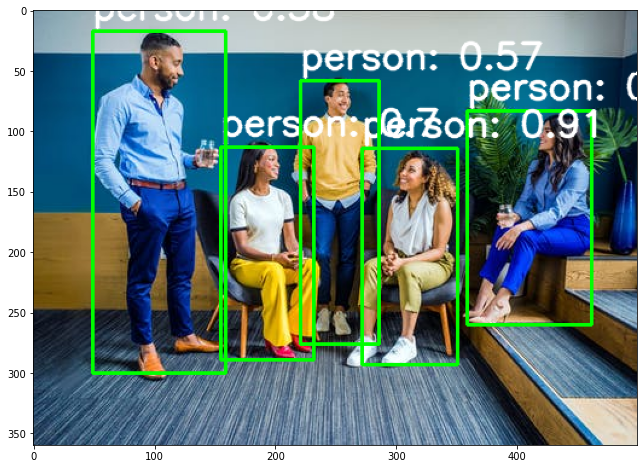

In [26]:
#Visualize on image
visualize_output('Group Photo.jpeg', confidence_threshold=0.5)